<a href="https://colab.research.google.com/github/hersheythings/machine_learning_portfolio/blob/main/dsschool_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1st. Train, Test 데이터셋 구조 확인

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ds/train.csv", index_col="PassengerId")
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ds/test.csv", index_col="PassengerId")
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2nd. EDA with 시각화, 피봇 라이브러리

* 좋은 데이터 사이언티스트는 전처리와 학습 절차에 앞서, EDA를 다각적으로 수행하면서 데이터 자체에 대한 분석을 선행함

* 모든 피처와 데이터 구조, 데이터 간 상관관계 등을 사전적으로 이해하는 절차



In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

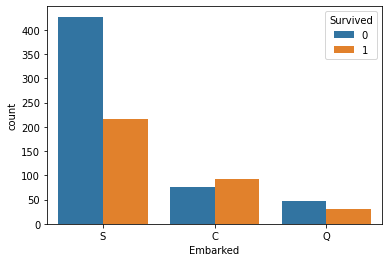

In [ ]:
sns.countplot(data=train, x="Embarked", hue="Survived")

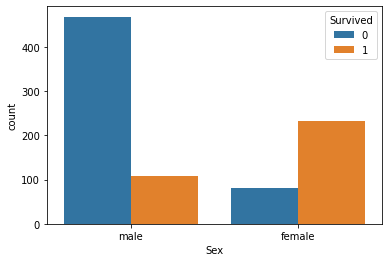

In [ ]:
sns.countplot(data=train, x="Sex", hue="Survived")

In [ ]:
pd.pivot_table(train, index="Sex", values="Survived")

,Survived
Sex,
female,0.742038
male,0.188908


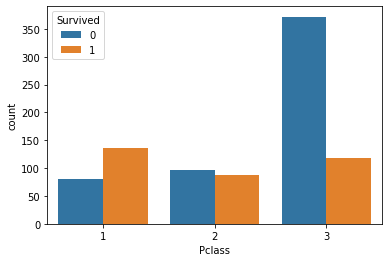

In [ ]:
sns.countplot(data=train, x="Pclass", hue="Survived")

In [ ]:
pd.pivot_table(train, index="Pclass", values="Survived")

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


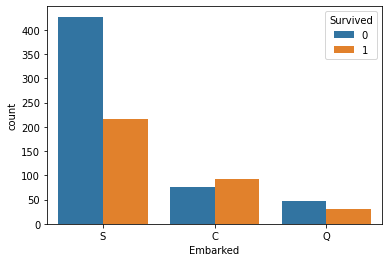

In [ ]:
sns.countplot(data=train, x="Embarked", hue="Survived")

In [ ]:
pd.pivot_table(train, index="Embarked", values="Survived")

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


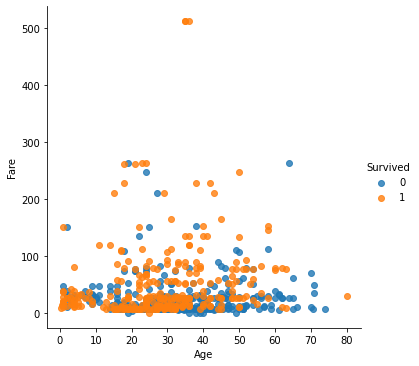

In [ ]:
sns.lmplot(data=train, x="Age", y="Fare", hue="Survived", fit_reg=False)

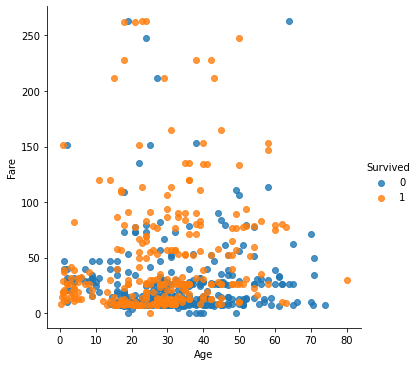

In [ ]:
lower_fare = train[train["Fare"] < 500]
sns.lmplot(data=lower_fare, x="Age", y="Fare", hue="Survived", fit_reg=False)

## 3rd. 전처리(Preprocessing)

scikit-learn 에서 제공하는 머신러닝 알고리즘에 데이터를 넣을 수 있는 기본 조건은 다음과 같습니다.

*   모든 데이터는 숫자(정수형, 소수점 등)로 구성되어 있어야 한다.
*   데이터에 빈 값이 없어야 한다.

먼저 타이타닉 데이터에 있는 세 컬럼(Sex, Fare, Embarked)을 전처리하는 과정을 진행해보자

### 1. Encode Sex

훈련 데이터와 테스트 데이터를 각각 전처리해줘야 함

####   1) 훈련 데이터 전처리

In [ ]:
train.loc[train["Sex"]== "male", "Sex_encode"] = 0
train.loc[train["Sex"]== "female", "Sex_encode"] = 1

## male, female 각각 0과 1로 인코딩하여 새로운 컬럼에 지정 
## 전처리를 할때에는 항상 원본을 유지하고 새로운 컬럼을 만들어서 할당하는게 옳다

In [ ]:
print(train.shape)
## 원래 11개의 컬럼이었는데, 위에서 "Sex_encode" 컬럼을 추가함으로써 12개의 컬럼이 출력

train[["Sex", "Sex_encode"]].head()
## 0과 1로 구성된 Sex_encode 데이터를 볼 수 있음 (feature를 피팅할때 0과 1로 학습시켜야 함으로)

(891, 12)


,Sex,Sex_encode
PassengerId,,
1,male,0.0
2,female,1.0
3,female,1.0
4,female,1.0
5,male,0.0


#### 2) 테스트 데이터 전처리

In [ ]:
test.loc[test["Sex"]=="male", "Sex_encode"] = 0
test.loc[test["Sex"]=="female", "Sex_encode"] = 1

print(test.shape)

test[["Sex", "Sex_encode"]].head()

(418, 11)


,Sex,Sex_encode
PassengerId,,
892,male,0.0
893,female,1.0
894,male,0.0
895,male,0.0
896,female,1.0


### 2. Encode Embarked


* C == 0
* S == 1
* Q == 2

위처럼 인코딩을 하되, 문제가 발생함.

C, S, Q는 서로 Mutually Exclusive하지만, 컴퓨터가 인식하기에는 S*2 = Q로 인식할 수 있음. 따라서, 원핫인코딩을 통해 서로 각기 다른 지역임을 컴퓨터에게 알려줘야 함. 이렇게 각 피쳐에 연산을 해도 동일 피쳐로 인식하지 않도록 하는 방법을 원핫인코딩이라고 함.

* C == [1,0,0]
* S == [0,1,0]
* Q == [0,0,1]

이제 C, S, Q를 좀 더 컴퓨터스럽게 바꿔보자. 컴퓨터에서 True는 1을, False는 0을 의미한다.

* C == [True, False, False]
* S == [False, True, False]
* Q == [False, False, True]

이제 One Hot Encoding을 코드로 구현해보자. 마찬가지로 훈련 데이터와 테스트 데이터를 각각 전처리한다.

#### 1) 훈련 데이터 전처리

In [ ]:
train["Embarked_C"] = train["Embarked"] == "C" # =을 써서 논리연산을 한 것 (Boolean)
train["Embarked_S"] = train["Embarked"] == "S"
train["Embarked_Q"] = train["Embarked"] == "Q"
print(train.shape)
train[["Embarked","Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(891, 15)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
1,S,False,True,False
2,C,True,False,False
3,S,False,True,False
4,S,False,True,False
5,S,False,True,False


#### 2) 테스트 데이터 전처리

In [ ]:
test["Embarked_C"] = test["Embarked"] == "C" # =을 써서 논리연산을 한 것 (Boolean)
test["Embarked_S"] = test["Embarked"] == "S"
test["Embarked_Q"] = test["Embarked"] == "Q"
print(test.shape)
test[["Embarked","Embarked_C", "Embarked_S", "Embarked_Q"]].head()

(418, 14)


,Embarked,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,
892,Q,False,False,True
893,S,False,True,False
894,Q,False,False,True
895,S,False,True,False
896,S,False,True,False


### 3. Fill in Missing Fare (Null값 채우기)

사이킷런 머신러닝 알고리즘에 데이터를 넣어줄 땐 항상 데이터 값이 채워져있어야 함(피봇 테이블처럼). 만약 NaN(Null) 값이 있다면 머신러닝 알고리즘이 에러를 뱉어냄. 

현재 test 데이터셋 안에 빈 값이 있는데, 바로 1044번 승객의 Fare 셀이 비어있음. 따라서 이 비어있는 Fare 값을 Decision Tree 알고리즘에 넣기 위해서는 1044번 승객의 Fare를 다른 무언가의 값으로 대체해줘야 함.

In [ ]:
test[test["Fare"].isnull()]
## Fare 컬럼에 NaN이 들어가있음을 확인 가능
## Null 값을 채우는 가장 일반적인 방법은 train 데이터의 운임요금(Fare)의 평균(mean)을 집어넣는 것 (train["Fare"].mean()) 
## 하지만 전체 test 데이터중에 단 하나의 값만 비어있기 때문에, 0을 넣어도 정확도의 손해 없이 잘 동작할 것 같다.

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encode,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0.0,False,True,False


#### 1) 훈련 데이터 전처리

In [ ]:
train["Fare_fillin"] = train["Fare"]
print(train.shape)
train[["Fare", "Fare_fillin"]].head()

(891, 16)


,Fare,Fare_fillin
PassengerId,,
1,7.2500,7.2500
2,71.2833,71.2833
3,7.9250,7.9250
4,53.1000,53.1000
5,8.0500,8.0500


#### 2) 테스트 데이터 전처리

In [ ]:
test["Fare_fillin"] = test["Fare"]
print(test.shape)
test[["Fare", "Fare_fillin"]].head()

(418, 15)


,Fare,Fare_fillin
PassengerId,,
892,7.8292,7.8292
893,7.0000,7.0000
894,9.6875,9.6875
895,8.6625,8.6625
896,12.2875,12.2875


In [ ]:
## Test 데이터셋의 널값을 0으로 재지정

test.loc[test["Fare"].isnull(), "Fare_fillin"] = 0

## 이후 다시 한 번 test 데이터셋에서 Fare가 비어있는 승객을 검색해보자. (Null이 채워졌는지 확인)
test.loc[test["Fare"].isnull(), ["Fare", "Fare_fillin"]]

,Fare,Fare_fillin
PassengerId,,
1044,NaN,0.0


## 4th. Train (학습)

이제, 전처리를 완료한 데이터셋을 활용해 Decision Tree를 학습시켜보자.

Decision Tree는 전형적인 지도학습 알고리즘 중 하나로, Supervised Learning 알고리즘을 학습시키기 위해서는 2가지 타입의 데이터가 필요함.

* Label : 라벨 내지 타겟 변수(Target Variable)이라고 부름. 쉽게 말해 정답 데이터임. 타이타닉 경진대회에서는 생존 여부(Survived)가 모델이 예측해내야 하는 타겟 값, 즉  라벨이 될 것.
* Feature : 정답을 맞추는 데에 도움이 되는 값들임. 타이타닉 데이터에서는 Label을 제외한 모든 property들이 대부분 피쳐임.

우리는 이번 코드에서, 다음 컬럼을 각각 Feature와 Label로 활용할 것임.

* Label : Survived
* Feature : Pclass, Sex_encode, Fare_fillin, Embarked_C, Embarked_S, Embarked_Q

그리고 위 조건을 반영하여 train, test 데이터를 다음의 3가지 형태 값으로 나누어 정의할 것임

* X_train : train 데이터의 feature
* X_test : test 데이터의 feature
* Y_train : train 데이터의 라벨

참고로, Y_test는 존재하지 않음. test 데이터에는 생존 여부를 나타내는 컬럼이 있지 않음. 왜냐? 우리의 목표 자체가 y_test에 없는 컬럼인 survived 값을 예측해내는 것이기 때문에. 이때 X_train, X_test, Y_train 값을 활용해서 test["Survived"] 컬럼을 예측해내는 것이 머신러닝 알고리즘이 해내는 일임.

이제, feature와 label을 새롭게 정의한 뒤 X_train, X_test, Y_train 데이터셋을 만들어보도록 하자.

In [ ]:
# feature_names 컬럼 만들기
feature_names = ["Pclass", "Sex_encode", "Fare_fillin", "Embarked_C", "Embarked_S", "Embarked_Q"]
feature_names

['Pclass',
 'Sex_encode',
 'Fare_fillin',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q']

In [ ]:
# 생존 여부를 Label로 지정하기
label_name = "Survived"
label_name

'Survived'

In [ ]:
# 앞서 정의한 feature를 활용해 X_train 데이터셋을 정의하자
X_train=train[feature_names]
print(X_train.shape)
X_train.head()

(891, 6)


,Pclass,Sex_encode,Fare_fillin,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,
1,3,0.0,7.2500,False,True,False
2,1,1.0,71.2833,True,False,False
3,3,1.0,7.9250,False,True,False
4,1,1.0,53.1000,False,True,False
5,3,0.0,8.0500,False,True,False


In [ ]:
# 앞서 정의한 feature를 활용해 X_test 데이터셋을 정의하자
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(418, 6)


,Pclass,Sex_encode,Fare_fillin,Embarked_C,Embarked_S,Embarked_Q
PassengerId,,,,,,
892,3,0.0,7.8292,False,False,True
893,3,1.0,7.0000,False,True,False
894,2,0.0,9.6875,False,False,True
895,3,0.0,8.6625,False,True,False
896,3,1.0,12.2875,False,True,False


In [ ]:
#앞서 정의한 label을 활용해 train 데이터의 label을 정의
# label_name 컬럼을 따로 지정해준 것이 아니라, 값만 위에서 할당해준 것이기 때문에 컬럼이 없는 형태로 출력됨
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(891,)


PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

#### Decision Tree 사용하기

우리는 앞서 X_train, X_test, y_train 데이터셋을 모두 만들었다. 이제 이 데이터를 활용해서 Decision Tree 알고리즘을 학습시켜보자, Decision Tree는 사이킷런을 통해 사용할 수 있다.

사이킷런에서 제공하는 머신러닝 알고리즘의 기능 2가지는 다음과 같다.

* Fit : 머신러닝 알고리즘을 학습시키는 기능. Fit을 하기 위해서는 train 데이터가 필요하고, 여기서는 X_train과 y_train 데이터에 해당.
* Predict : Fit이 끝나면 test 데이터의 label 값을 예측하는 기능. predict를 하기 위해서는 test 데이터의 feature(여기서는 X_test)가 필요함.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# 학습시키는 depth는 5로 하고, dicision tree 알고리즘의 이름은 "model"로 만들어주자.
model = DecisionTreeClassifier(max_depth=5) 
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# 모델을 만들었으면 학습을 시켜줘야겠지? fit 기능을 실행해서 피쳐와 라벨을 먹이로 주자
model.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### 학습 알고리즘 시각화하기

바로 위 코드 model.fit(X_train, y_train) 함수를 시각화해서 보여줄 수도 있다. 

In [ ]:
pip install graphviz ## 먼저 학습 알고리즘을 그래프 형태로 시각화해주는 프로그램인 graphviz를 설치

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

# sklearn의 tree 모듈에서 decision tree를 시각화할 수 있는 export_graphviz를 가져왔다.
# export_graphviz로 시각화를 할때 다음의 param을 넣어야한다.
## 1) model : 시각화할 트리 알고리즘
## 2) feature_names : 트리를 만들때 사용한 feature들의 이름
## 3) class_names : 살았을 경우 시각화에서 어떻게 표현할 것인지(Survived), 반대로 죽었을 경우 시각화에서 어떻게 표현할 것(Perish)인지를 알려줌
## 4) out_file : 시각화 결과를 저장할 파일명. 여기에서는 파일로 따로 저장 안하므로 None을 주면 됨
## 마지막으로 시각화한 결과는 dot_tree라는 이름의 변수에 새롭게 지정해주자

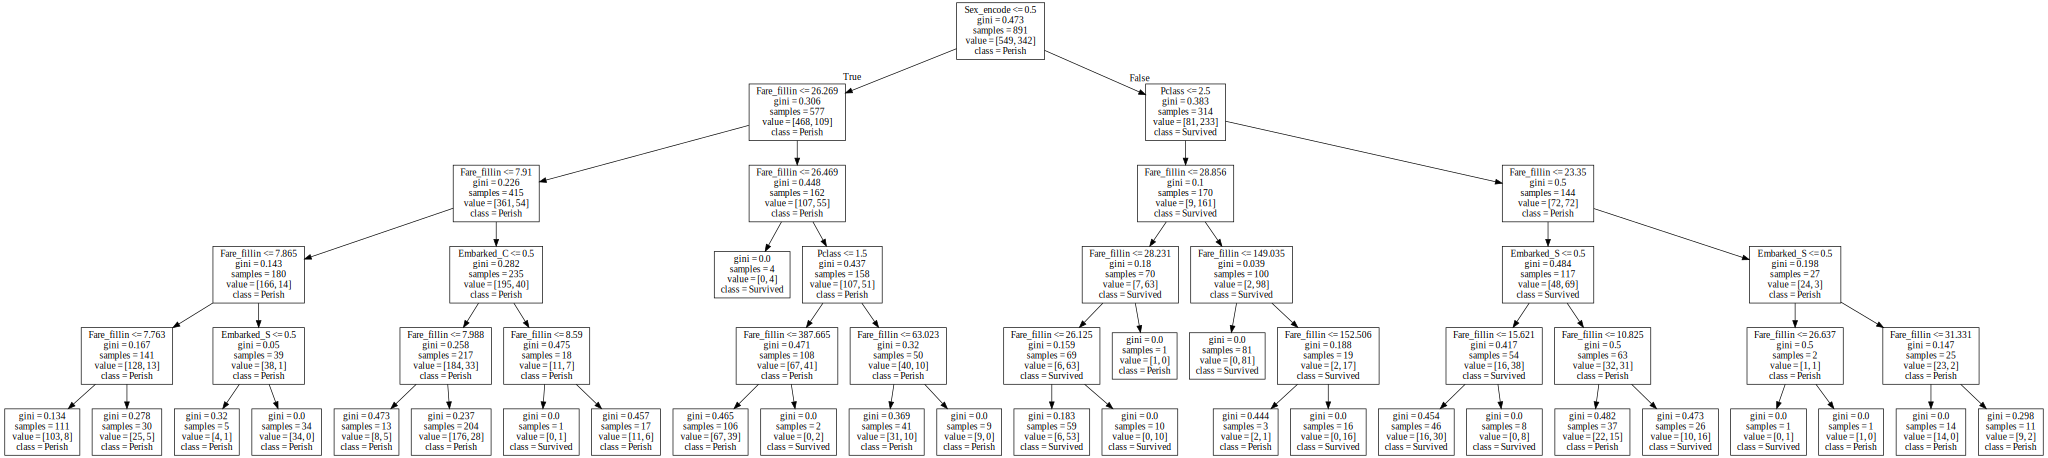

In [ ]:
dot_tree = export_graphviz(model, feature_names=feature_names, class_names=["Perish", "Survived"], out_file=None)
graphviz.Source(dot_tree) #Source라는 기능을 통해 dot_tree를 시각화

## 5th. 예측 (Predict)

Decision Tree가 성공적으로 학습이 되었다면, 남은 것은 이 Decision Tree를 활용해 테스트 데이터에 있는 승객의 생존/사망 여부를 예측하는 것임. 

예측은 model.predict 기능으로 할 수 있으며, 이 때 test 데이터의 feature인 X_test가 필요함


In [ ]:
# fit이 끝났으면, predict라는 기능을 사용하여 생존 여부(Survived)를 예측합니다.
# predict의 실행이 끝나면 test 데이터의 생존 여부(Survived)를 반환하며, 이를 predictions라는 이름의 변수에 할당합니다.
predictions = model.predict(X_test)

# predictions 변수에 할당된 데이터의 사이즈를 출력
# 출력은 (row, column) 으로 표시되나, column이 없기 때문에 (row,) 형태로 표시
print(predictions.shape)

# predictions 변수에 값이 너무 많기 때문에, 상위 10개만 출력
predictions[0:100]

(418,)


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])